In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import RegularGridInterpolator
from scipy.stats import binned_statistic_2d
from sklearn.linear_model import LinearRegression

from utils import *

import warnings
warnings.filterwarnings("ignore")

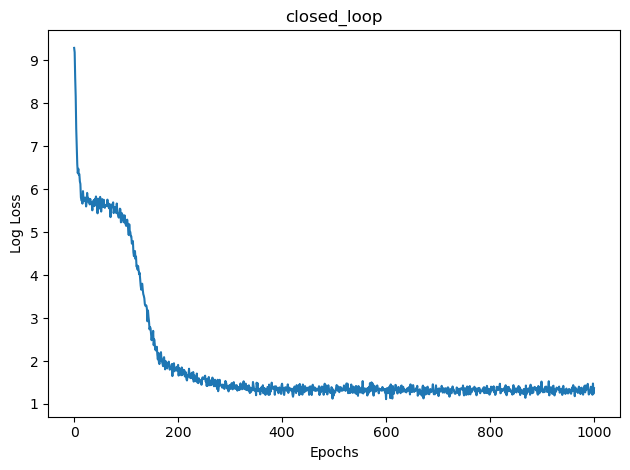

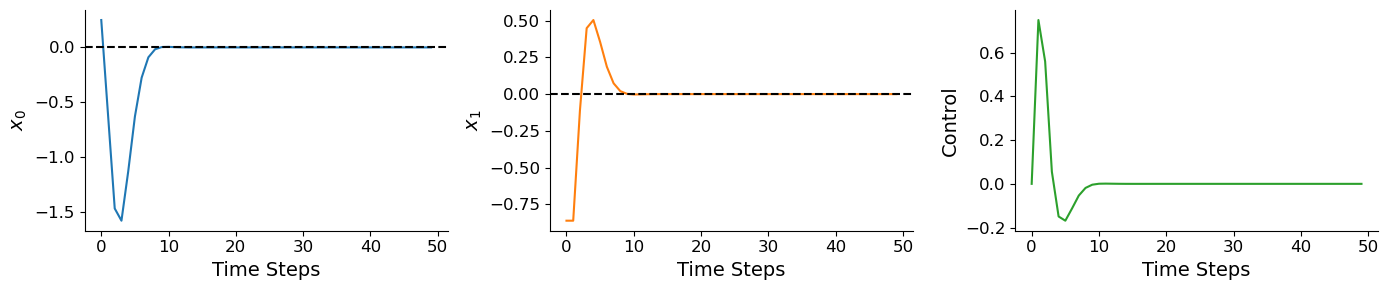

State cost: 8.9789


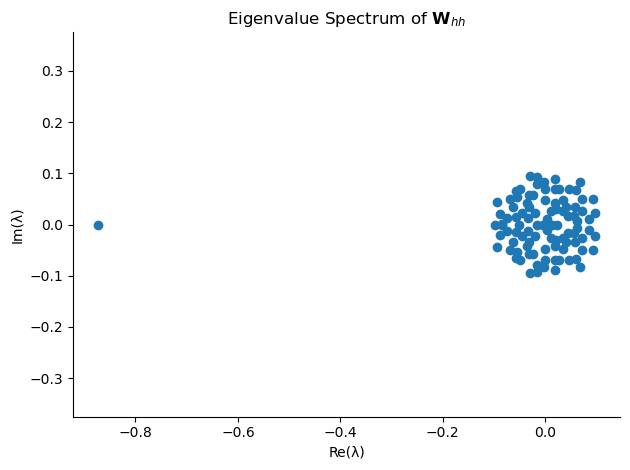

In [2]:
# System and training parameters
K = 2           # System dimension
M = 1           # Control output size
C = 1           # Input dimension
dt = 1          # Time step
low_d = False   # Use low-dimensional RNN
opt = 'SGD'     # Optimizer type
lr = 1e-2       # Learning rate

# Initialize system (k-th order integrator)
system = k_integrator_torch(k=K, dt=dt, c=C, m=M, noise=0.0, clamp=False)
x_target = np.zeros(system.k)

# Controller setup
hidden_size = system.k if low_d else 100
phi = 'tanh'
save_model = 1

controller = ct_rnn_controller(
    input_size=system.c,
    hidden_size=hidden_size,
    output_size=system.m,
    phi=phi,
    manually_initialize=True,
    with_bias=False,
    train_Wih=True,
    train_Whh=True,
    train_Who=True,
    small_scale=True,
    Wih_start_big=False,
    g=0.1,
    dt=dt,
    tau=1,
    tracking_task=False,
    RL=False
)

# Training loop
net_name = 'closed_loop'
loss = train_rnn(
    net_num=net_name,
    path='full_rnn_non_linear',
    controller=controller,
    system=system,
    x_target=x_target,
    teacher=None,
    LR=lr,
    num_epochs=1001,
    opt=opt,
    w_grad_clip=True,
    batch_size=100,
    num_steps=50,
    dt=dt,
    reg_U=0.005,
    save_model=save_model,
    log=False
)

# Plot training loss (log-scale)
plt.plot(np.log(loss))
plt.title(net_name)
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.tight_layout()
plt.show()

# Simulate trained controller
system_state, control_u, hidden_state, state_loss, control_loss = simulate_rnn(
    controller=controller,
    system=system,
    k=system.k,
    num_steps=50,
    x_target=np.zeros(system.k),
    batch_size=1,
    init_con=torch.rand(system.k, 1) * 2 - 1
)

# Plot system state and control output
fig, ax = plt.subplots(1, system.k + 1, figsize=(14, 3))

# Plot each system dimension
for i in range(system.k):
    ax[i].plot(system_state[:, i].squeeze(), color=sns.color_palette('tab10')[i])
    ax[i].axhline(y=x_target[i], color='k', ls='--', label='Target')
    ax[i].set_xlabel('Time Steps', size=14)
    ax[i].set_ylabel(f'$x_{i}$', size=14)
    ax[i].tick_params(axis='both', which='major', labelsize=12)

# Plot control signal
for j in range(M):
    ax[system.k].plot(control_u[:, 0, j], color=sns.color_palette('tab10')[system.k + j])
    ax[system.k].set_xlabel('Time Steps', size=14)
    ax[system.k].set_ylabel('Control', size=14)
    ax[system.k].tick_params(axis='both', which='major', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

# Final state cost
print(f'State cost: {np.sum(state_loss):.4f}')

# Plot eigenvalues of recurrent matrix
e_vals, _ = np.linalg.eig(controller.Whh.detach().numpy())
plt.scatter(e_vals.real, e_vals.imag)
plt.title('Eigenvalue Spectrum of $\mathbf{W}_{hh}$')
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.axis('equal')
sns.despine()
plt.tight_layout()
plt.show()


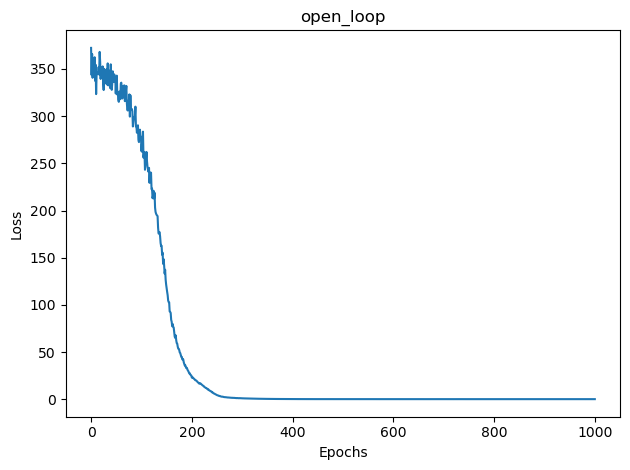

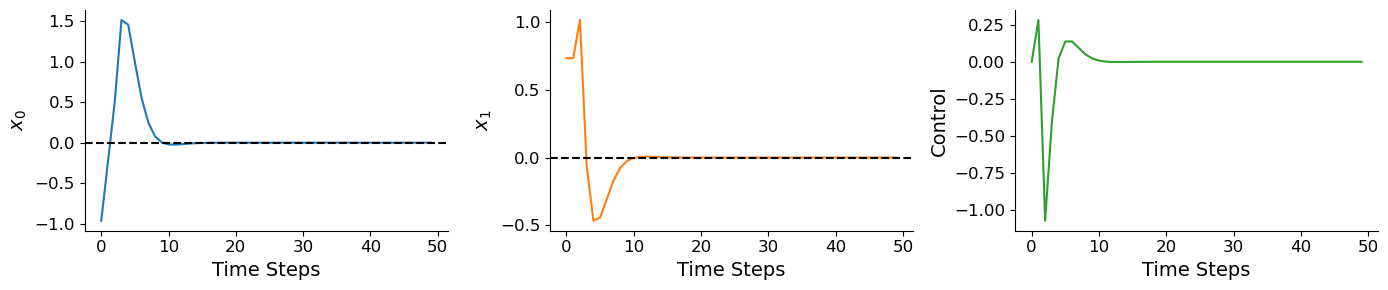

State cost: 9.6444


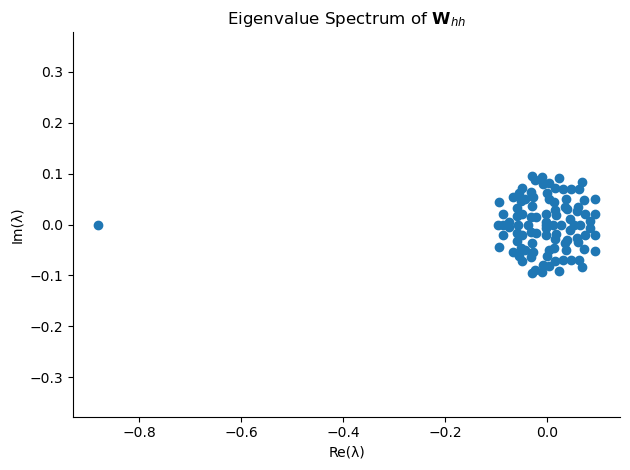

In [3]:
# System and training parameters
K = 2           # System dimension
M = 1           # Control output size
C = 1           # Input dimension
dt = 1          # Time step
low_d = False   # Use low-dimensional controller
opt = 'SGD'
lr = 1e-2

# Initialize system
system = k_integrator_torch(k=K, dt=dt, c=C, m=M, noise=0.0, clamp=False)
x_target = np.zeros(system.k)

# Set hidden size based on low_d flag
hidden_size = system.k if low_d else 100
phi = 'tanh'
save_model = 1

# Define student controller (to be trained)
controller2 = ct_rnn_controller(
    input_size=system.c,
    hidden_size=hidden_size,
    output_size=system.m,
    phi=phi,
    manually_initialize=True,
    with_bias=False,
    train_Wih=True,
    train_Whh=True,
    train_Who=True,
    small_scale=True,
    Wih_start_big=False,
    g=0.1,
    dt=dt,
    tau=1,
    tracking_task=False,
    RL=False
)

# Optional initialization for low-dimensional controller
if low_d:
    vector1 = np.zeros(hidden_size)
    vector1[0] = 1.0
    vector2 = np.full(hidden_size, 0.01)
    vector2[0] = 0.0

    with torch.no_grad():
        controller2.Wih.copy_(torch.Tensor(vector1.reshape(1, hidden_size)))
        controller2.Who.copy_(torch.Tensor(vector2.reshape(hidden_size, 1)))

# Define teacher controller
controller_teacher = ct_rnn_controller(
    input_size=system.c,
    hidden_size=hidden_size,
    output_size=system.m,
    phi=phi,
    manually_initialize=True,
    with_bias=False,
    train_Wih=True,
    train_Whh=True,
    train_Who=True,
    small_scale=True,
    Wih_start_big=False,
    g=0.1,
    dt=dt,
    tau=1,
    RL=False
)

# Load pre-trained parameters for student and teacher
controller2.load_state_dict(torch.load('models/full_rnn_non_linear/closed_loop/epoch_0.pth')['model_state'])
controller_teacher.load_state_dict(torch.load('models/full_rnn_non_linear/closed_loop/epoch_1000.pth')['model_state'])

# Train student controller via teacher-student setup (open-loop)
net_name = 'open_loop'
loss2 = train_rnn_teacher_student(
    net_num=net_name,
    path='full_rnn_non_linear',
    controller_teacher=controller_teacher,
    controller=controller2,
    system=system,
    x_target=x_target,
    white_noise=1,
    LR=lr,
    num_epochs=1001,
    opt=opt,
    w_grad_clip=True,
    batch_size=100,
    num_steps=50,
    dt=dt,
    reg_U=0,
    save_model=save_model,
    log=False
)

# Plot training loss
plt.plot(loss2)
plt.title(net_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# Simulate student controller performance
system_state, control_u, hidden_state, state_loss, control_loss = simulate_rnn(
    controller=controller2,
    system=system,
    k=system.k,
    num_steps=50,
    x_target=np.zeros(system.k),
    batch_size=1,
    init_con=torch.rand(system.k, 1) * 2 - 1
)

# Plot system state and control output
fig, ax = plt.subplots(1, system.k + 1, figsize=(14, 3))

# State variables
for i in range(system.k):
    ax[i].plot(system_state[:, i].squeeze(), color=sns.color_palette('tab10')[i])
    ax[i].axhline(y=x_target[i], color='k', ls='--')
    ax[i].set_xlabel('Time Steps', size=14)
    ax[i].set_ylabel(f'$x_{i}$', size=14)
    ax[i].tick_params(axis='both', which='major', labelsize=12)

# Control output
for j in range(M):
    ax[system.k].plot(control_u[:, 0, j], color=sns.color_palette('tab10')[system.k + j])
    ax[system.k].set_xlabel('Time Steps', size=14)
    ax[system.k].set_ylabel('Control', size=14)
    ax[system.k].tick_params(axis='both', which='major', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

# Print total state cost
print(f'State cost: {np.sum(state_loss):.4f}')

# Plot eigenvalues of the trained recurrent matrix
e_vals, _ = np.linalg.eig(controller2.Whh.detach().numpy())
plt.scatter(e_vals.real, e_vals.imag)
plt.title('Eigenvalue Spectrum of $\mathbf{W}_{hh}$')
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.axis('equal')
sns.despine()
plt.tight_layout()
plt.show()


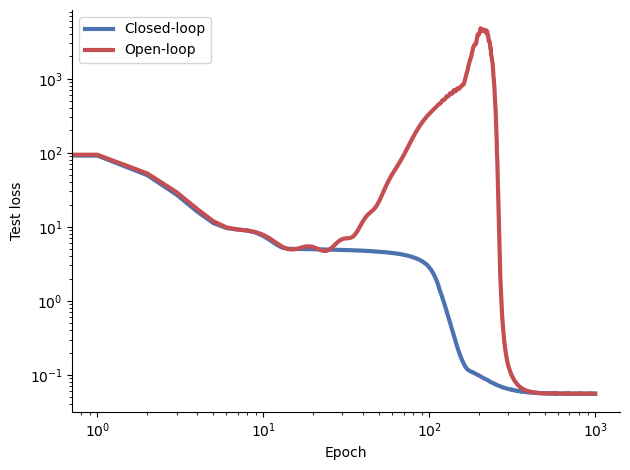

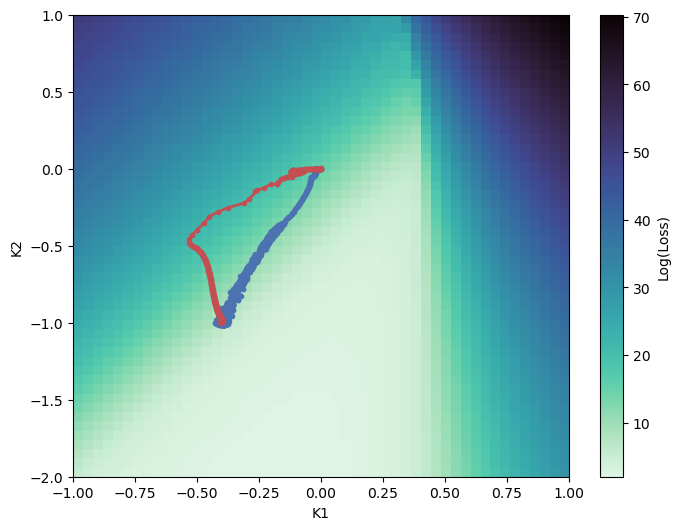

In [4]:
all_paths = [
        
            f'models/full_rnn_non_linear/closed_loop',
            f'models/full_rnn_non_linear/open_loop',
            
]

all_loss = np.zeros((len(all_paths),1000))
all_k = np.zeros((len(all_paths),1000,2))
num_steps = int(50/dt) 
batch_size = 10
x_t = torch.zeros(system.k, batch_size)
DROP = 1

x_t[0, :] = torch.rand(batch_size) * 2 - 1
x_t[1, :] = torch.rand(batch_size) * 2 - 1 

for n,path in enumerate(all_paths):

    # hid_size = all_hidden_size[n]

    for ep in range(1000):
        controller = ct_rnn_controller(system.c, hidden_size, system.m, phi=phi, dt=dt)
        controller.load_state_dict(torch.load(f'{path}/epoch_{ep}.pth')['model_state'])
        p = create_p_matrix_from_rnn(system,controller)

        system_state, control_u, hidden_state, state_loss, control_loss = simulate_rnn(
                                                                controller,
                                                                system,
                                                                k=system.k,
                                                                num_steps=num_steps,
                                                                x_target=np.zeros(system.k),
                                                                batch_size=batch_size,
                                                                init_con=x_t,)

        all_loss[n,ep] = np.mean(state_loss.squeeze())
        XX = system_state[DROP:].swapaxes(1, 2).reshape((num_steps-DROP)*batch_size,2)
        y = control_u[DROP:].flatten()
        
        reg = LinearRegression(fit_intercept=False)
        reg.fit(XX, y)
        all_k[n,ep] = reg.coef_


colors = [sns.color_palette('deep')[0],sns.color_palette('deep')[3],]
names = ['Closed-loop','Open-loop'] 
for i in range(len(all_paths)):
    plt.plot((all_loss[i,:]),color=colors[i],label=names[i],lw=3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()

# System parameters
dt = 1
x_target = np.array([0.0, 0.0])  
A = np.array([[1, dt],
              [0, 1]])  
B = np.array([[0],
              [dt]])  

Q = np.eye(2)*1
R = np.array([[1]]) * 0
P = scipy.linalg.solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
K_LQR = K.copy()
all_k0 = np.linspace(-1.2, 0.5, 50)
all_k1 = np.linspace(-1.2, 0.5, 50)

kk0=[]
kk1=[]
zzz=[]

for k0 in all_k0:
    for k1 in all_k1:   
        
        K[0][0] = k0
        K[0][1] = k1
        num_steps = int(50/dt)
        N = 1
        state_loss_total = 0
        control_loss_total = 0
        
        for n in range(1):
            x = np.array([0.0, 0.0])  # Initialize the system state
            x[0] = 1  # Random start position
            x[1] = 1  # Random start velocity  
            
            # Simulation loop
            for t in range(num_steps):
                
                # Compute control input using the LQR feedback law
                u = K @ (x - x_target)
                
                # Apply control input to the system
                w_t = np.random.randn(2) * 0.00  # Optional noise
                x = A @ x + B.flatten() * u + w_t * np.sqrt(dt)
        
                # Compute the state and control losses
                state_loss = np.sum((x-x_target)**2)
                control_loss = u**2
                
                # Accumulate the losses
                state_loss_total += state_loss.item()*dt
                control_loss_total += control_loss.item()*dt

        kk0.append(k0)
        kk1.append(k1)
        z = np.log( np.array(state_loss_total) ) # + np.array(control_loss_total)
        zzz.append(z)


from scipy.stats import binned_statistic_2d

def sim_p_reduce(P, num_steps=5, init_con_x=[1, 1]):
    traj = []
    x0, x1 = init_con_x
    traj.append((x0, x1))
    
    for _ in range(num_steps):
        x0, x1 = P @ np.array([x0, x1])
        traj.append((x0, x1))
    
    return np.array(traj)

# Define grid for k1, k2
all_a = np.linspace(-1.2, .5, 200)
all_b = np.linspace(-1.2, .5, 200)

all_stability = []

for a in all_a:
    for b in all_b:
        # Define system matrix
        p_red = np.array([[1, dt],
                          [dt*a, 1 + dt*b]])
        
        eigvals, _ = np.linalg.eig(p_red)
        
        # Stability classification
        if np.all(np.abs(eigvals) < 1):
            stability_label = 2  # Stable
        else:
            complex_mask = (np.abs(eigvals) > 1) & (np.imag(eigvals) != 0)
            stability_label = 1 if np.any(complex_mask) else 0  # Unstable (oscillatory or real)

        all_stability.append(stability_label)

# Reshape for plotting
X, Y = np.meshgrid(all_a, all_b)
Z = np.array(all_stability).reshape(len(all_b), len(all_a)).T

plt.figure(figsize=(8, 6))
plt.imshow(np.array(zzz).reshape(50,50).T, extent=[-1, 1, -2, 1], origin="lower", aspect="auto", cmap="mako_r")
plt.colorbar(label="Log(Loss)")

for i,name in enumerate(all_paths):
    plt.plot(all_k[i,:,0],all_k[i,:,1], lw=2 , linestyle='-', marker='.',color=colors[i])


plt.xlabel("K1")
plt.ylabel("K2")
plt.show()

